In [1]:
%matplotlib inline

import sqlite3

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set_style("white")
sns.set_palette(sns.color_palette("dark"))
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('seaborn-white')

data_dir = '../data/'

Data Processing Steps
1. Filtering Missing / Invalid Entries
2. Cleaning Improper GPS Coordinates
3. Match Collisions to Highway Segments

Results in `df_switrs.csv`

In [2]:
def get_sql_df(query, sql_file = data_dir + "switrs.sqlite3"):
    """Runs a SQL query over a SQLite database to extract a DataFrame."""

    print 'Running SQL query...'

    with sqlite3.connect(sql_file) as conn:
        df = pd.read_sql_query(query, conn, parse_dates=get_date_columns(query))

        return df
    
def get_date_columns(query):
    """Find fields in query to parse as date columns for the DataFrame."""

    fields = ["Collision_Date", "Process_Date"]

    dates = [f for f in fields if f in query]

    return dates if dates else None


def get_time_col(df):
    """Split time string into an int array."""

    return df.str.split(':', n=3, expand=True).apply(pd.Series).astype(np.int32)

In [4]:
main_cols = [
    'Caltrans_County', 'Caltrans_District', 
    'State_Route', 'Side_of_Highway', 
    'Postmile', 'Latitude', 'Longitude', 
    'Collision_Date', 'Collision_Time'
]

query = "SELECT %s FROM Collision" % ', '.join(main_cols)

In [5]:
df_switrs = get_sql_df(query)

print '\nTotal Collisions:', len(df_switrs)
print 'From', df_switrs.Collision_Date.dt.date.min(), \
      'to',   df_switrs.Collision_Date.dt.date.max()
    
df_switrs.head()

Running SQL query...

Total Collisions: 7506133
From 2001-01-01 to 2016-12-31


In [6]:
for col in df_switrs:
    print '% 30s (%8s) - null: %d' % (col, df_switrs[col].dtype, sum(df_switrs[col].isnull()))

               Caltrans_County -   object - 5002412
             Caltrans_District -  float64 - 4668437
                   State_Route -  float64 - 4668438
               Side_Of_Highway -   object - 5002412
                      Postmile -  float64 - 4668438
                      Latitude -  float64 - 6055489
                     Longitude -  float64 - 6055489
                Collision_Date - datetime64[ns] - 0
                Collision_Time -   object - 63770


In [13]:
df_switrs.State_Route.replace(0, np.nan, axis=1, inplace=True)

/home/julin/Programs/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3416: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warn('the "axis" argument is deprecated and will be removed in'


In [7]:
pop = [
    [2001,34485623], [2002,34876194], [2003,35251107], [2004,35558419], 
    [2005,35795255], [2006,35979208], [2007,36226122], [2008,36580371], 
    [2009,36961664], [2010,37253956], [2011,37701901], [2012,38062780], 
    [2013,38431393], [2014,38802500], [2015,39032444], [2016,39296476],
]

pop_years = [p[0] for p in pop]
pop_pops  = [p[1] for p in pop]

In [8]:
def show_accidents_per_year(df_col):    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    plt.title('Total Accidents per Year', fontsize=24)
    plt.xlabel('Year', fontsize=20)
    plt.xticks(fontsize=16)
    plt.ylabel('Total Accidents', fontsize=20)
    plt.yticks(fontsize=14)
        
    for df in [df_col, df_col[~df_col.State_Route.isnull()]]:
        ax1.hist(df.Collision_Date.dt.year, 
             bins=range(2001, 2018), align='left');    

    ax2 = ax1.twinx() 
    
    ax2.plot(pop_years, np.array(pop_pops) / 1e6, c='red')
    plt.ylabel('Total Population [M]', fontsize=20)
    plt.yticks(fontsize=14)

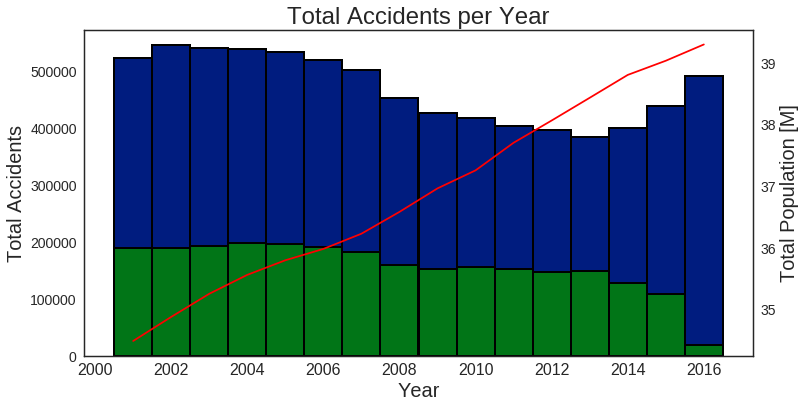

In [15]:
show_accidents_per_year(df_switrs)

In [156]:
df_switrs = df_switrs[(df_switrs.Collision_Date.dt.year >= 2010)
                    & (df_switrs.Collision_Date.dt.year <= 2015)
                    & (~df_switrs.State_Route.isnull())
                    & (~df_switrs.Caltrans_County.isnull())
                    & (~df_switrs.Side_Of_Highway.isnull())
                    & (~df_switrs.Collision_Time.isnull())]

In [159]:
for year in range(2010, 2016):
    print '%s - %d' %(year, len(df_switrs[df_switrs.Collision_Date.dt.year == year]))

2010 - 155154
2011 - 151365
2012 - 146832
2013 - 147884
2014 - 127436
2015 - 107746


In [158]:
df_switrs['Forward'] = df_switrs.Side_Of_Highway.apply(lambda x: x in ['N', 'E'])

df_switrs['Collision_Year']      = df_switrs.Collision_Date.dt.year
df_switrs['Collision_Month']     = df_switrs.Collision_Date.dt.month
df_switrs['Collision_Day']       = df_switrs.Collision_Date.dt.day
df_switrs['Collision_DayOfWeek'] = df_switrs.Collision_Date.dt.dayofweek 

df_switrs['Collision_Hour']   = get_time_col(df_switrs.Collision_Time)[0]
df_switrs['Collision_Minute'] = get_time_col(df_switrs.Collision_Time)[1]

df_switrs['Collision_Hours']   = df_switrs.Collision_Hour + df_switrs.Collision_Minute / 60.0
df_switrs['Collision_Minutes'] = df_switrs.Collision_Hour * 60.0 + df_switrs.Collision_Minute

In [21]:
def draw_collision_map(df):
    fig = plt.figure(figsize=(8, 8))
    plt.ylim(31, 43)
    plt.xlim(-125, -113)
    plt.scatter(df.Longitude, df.Latitude, s=0.8);
    
    return fig    

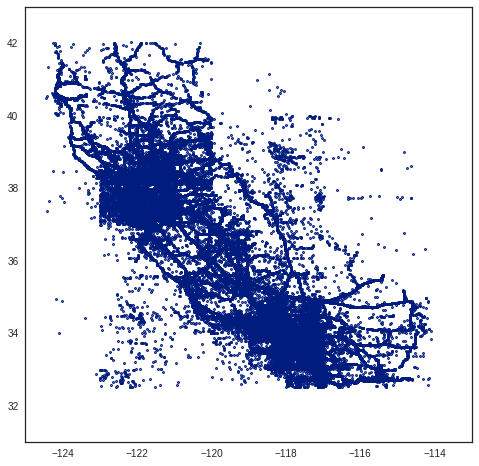

In [22]:
fig = draw_collision_map(df_switrs)

In [133]:
# Polygon Points
gps1 = (40.2, -124.7)
gps2 = (34.4, -120.6)
gps3 = (32.6, -117.2)
gps4 = (32.7, -114.5)
gps5 = (34.4, -113.9)
gps6 = (39.0, -120.0)
gps7 = (42.0, -120.0)
gps8 = (42.0, -124.2)

lines = [
    (gps1, gps2),
    (gps2, gps3),
    (gps3, gps4),
    (gps4, gps5),   
    (gps5, gps6),
    (gps6, gps7),
    (gps7, gps8),
    (gps8, gps1), 
]

def draw_collision_map_with_lines(df, lines):
    fig = draw_collision_map(df)    
    axes = fig.add_subplot(111)
    
    for l in lines:
        line = plt.Line2D([l[0][1], l[1][1]], [l[0][0], l[1][0]], linewidth=3, linestyle='solid', color='red')
        axes.add_line(line)
        
    return fig, axes

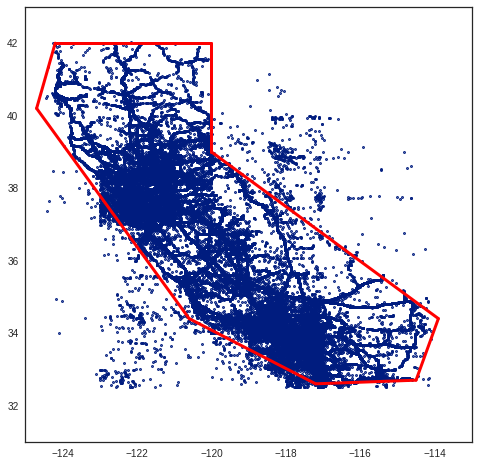

In [134]:
fig, axes = draw_collision_map_with_lines(df_switrs, lines)

In [174]:
def get_slope_eq(p1, p2):
    y1, x1 = p1
    y2, x2 = p2
    
    m = 1.0 * (y1 - y2) / (x1 - x2) if x1 != x2 else np.inf
    b = y1 - m * x1
    
    return m, b
    
print 'm = %- .4f, b = %- .4f' % get_slope_eq(gps1, gps2)
print 'm = %- .4f, b = %- .4f' % get_slope_eq(gps3, gps4)

m = -1.4146, b = -136.2049
m =  0.0370, b =  36.9407


In [178]:
def is_above_line(x, y, m, b):  
    return y >= m * x + b

def gps_to_xy(gps):
    return (gps[1], gps[0])
    
print is_above_line(-122, 30, *get_slope_eq(gps1, gps2)) # False
print is_above_line(-115, 40, *get_slope_eq(gps4, gps3)) # True
print is_above_line(-118, 40, *get_slope_eq(gps5, gps6)) # True

False
True
True


In [180]:
def check_line(lat, lng, gps1, gps2, above = True):
    return lng >= min(gps1[1], gps2[1]) \
        and lng <= max(gps1[1], gps2[1]) \
        and (above == is_above_line(lng, lat, *get_slope_eq(gps1, gps2)))

def is_in_bounds(gps):    
    lat, lng = gps
    
    if not lat or not lng:
        return False
                                          
    if check_line(lat, lng, gps1, gps2, False) \
    or check_line(lat, lng, gps2, gps3, False) \
    or check_line(lat, lng, gps3, gps4, False) \
    or check_line(lat, lng, gps4, gps5, False) \
    or check_line(lat, lng, gps5, gps6, True) \
    or check_line(lat, lng, gps7, gps8, True) \
    or check_line(lat, lng, gps8, gps1, True):
        return False
    
    return True 

t1 = (40, -122)
t2 = (32, -122)
t3 = (36, -119)
t4 = (40, -118)

print is_in_bounds(t1) # True
print is_in_bounds(t2) # False
print is_in_bounds(t3) # True
print is_in_bounds(t4) # False

True
False
True
False


In [182]:
def is_gps_valid(row):    
    return is_in_bounds((row.Latitude, row.Longitude)) \
        if not np.isnan(row.Latitude) else False

In [184]:
df_switrs['GPS_Valid'] = df_switrs.apply(is_gps_valid, axis=1)

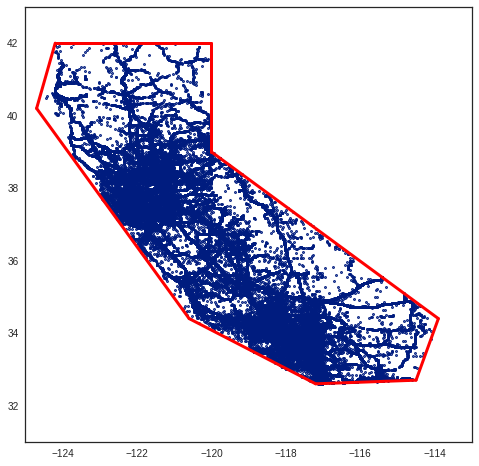

In [188]:
fig, axes = draw_collision_map_with_lines(df_switrs[df_switrs.GPS_Valid], lines)

In [190]:
def get_route_list(df):
    route_list = {}
    
    # Start by looking only at segments for a given year
    for year in df.Year.unique():
        route_list[year] = {}
        
        df_year = df[df.Year == year]
        
        # Then filter the collisions to their appropriate routes
        for route in df_year.Route.unique():
            route_list[year][route] = {}

            df_route = df_year[df_year.Route == route]

            # Then filter them to each county to match with the Postmile
            for county in df_route.County.unique():
                route_list[year][route][county] = df_route[df_route.County == county]

    return route_list

In [191]:
def get_highway_segment(data, route_list):
    """Assign a collision to a highway segment based on its Postmile code."""
    
    global print_year
    
    # Grab identifying information to locate corresponding segment
    year = data.Collision_Year
    route = data.State_Route
    county = data.Caltrans_County        
    
    if print_year != year:
        print 'Processing Collisions for %s' % year
        print_year = year    
    
    # There's a lot of collisions, so this gives a rough idea of progress
    if not (data.name % 10000):
        print '  Processing Event %8d' % data.name
    
    # Just in case, we'll default to an invalid segment
    last_segment = -1
    
    # If for some reason this isn't a valid road, give it an invalid segment number (-1)
    if year not in route_list \
    or route not in route_list[year] \
    or county not in route_list[year][route]:
        return last_segment     
    
    # Now we look at all the segments on the specific Route in the specific County
    for segment, row in route_list[year][route][county].iterrows():   
        
        # Don't bother checking invalid segments
        if np.isnan(row.Postmile):
            continue
                
        # Once it goes past the value, we assign the collision to the most recent segment
        # (We ignore prefix, so it's not completely accurate, but it's reasonably close!)
        if row.Postmile > data.Postmile:
            return last_segment
            
        # Keep track of the last valid segment
        last_segment = row.Segment_ID

In [192]:
df_aadt = pd.DataFrame.from_csv(data_dir + 'df_aadt.csv')

min_year = df_aadt.Year.min()
max_year = df_aadt.Year.max()

df_switrs = df_switrs[(df_switrs.Collision_Year >= min_year) 
                    & (df_switrs.Collision_Year <= max_year)]

route_list = get_route_list(df_aadt)

print_year = min_year - 1

df_switrs['Segment_ID'] = df_switrs.apply(get_highway_segment, 
                                          axis=1, args=(route_list, ))
df_switrs.Segment_ID.fillna(-1, inplace=True)
df_switrs.Segment_ID = df_switrs.Segment_ID.astype(np.int64)

print 'Complete!'

Processing Collisions for 2010
  Processing Event  4580000
  Processing Event  4590000
  Processing Event  4630000
  Processing Event  4660000
  Processing Event  4680000
  Processing Event  4690000
  Processing Event  4700000
  Processing Event  4720000
  Processing Event  4730000
  Processing Event  4750000
  Processing Event  4760000
  Processing Event  4780000
  Processing Event  4790000
  Processing Event  4820000
  Processing Event  4840000
  Processing Event  4850000
  Processing Event  4880000
  Processing Event  4920000
  Processing Event  4940000
  Processing Event  4950000
  Processing Event  4960000
  Processing Event  4970000
Processing Collisions for 2011
  Processing Event  5020000
  Processing Event  5030000
  Processing Event  5040000
  Processing Event  5050000
  Processing Event  5060000
  Processing Event  5080000
  Processing Event  5100000
  Processing Event  5120000
  Processing Event  5130000
  Processing Event  5170000
  Processing Event  5180000
  Processing E

In [193]:
print 'save_cols = ['
for col in df_switrs.columns:
    print "    '%s'," % col
print ']'

save_cols = [
    'Caltrans_County',
    'Caltrans_District',
    'State_Route',
    'Side_Of_Highway',
    'Postmile',
    'Latitude',
    'Longitude',
    'Collision_Date',
    'Collision_Time',
    'GPS_Valid',
    'Forward',
    'Collision_Year',
    'Collision_Month',
    'Collision_Day',
    'Collision_DayOfWeek',
    'Collision_Hour',
    'Collision_Minute',
    'Collision_Hours',
    'Collision_Minutes',
    'Segment_ID',
]


In [194]:
save_cols = [
    'Segment_ID',
    'State_Route',
    'Caltrans_District',
    'Caltrans_County',
    'Postmile',
    'Side_Of_Highway',
    'Forward',
#     'State_Highway_Indicator',
#     'Route_Suffix',
#     'Location_Type',
    'Latitude',
    'Longitude',
    'GPS_Valid',
#     'Collision_Date',
#     'Collision_Time',
    'Collision_Year',
    'Collision_Month',
    'Collision_Day',
    'Collision_DayOfWeek',
    'Collision_Hour',
    'Collision_Minute',
    'Collision_Hours',
    'Collision_Minutes',
]

In [195]:
df_switrs[save_cols].to_csv(data_dir + 'df_switrs.csv')

In [ ]:
# def get_state_loc(row):           
#     gps = (row.Latitude, row.Longitude)    
#     loc = geolocater.reverse(gps)
    
#     if not loc.address or not loc.raw['address'] or not loc.raw['address']['state']:
#         return None
    
#     return loc.raw['address']['state'] 

In [ ]:
# df_gps = df_switrs[~df_switrs.Latitude.isnull()]
# geolocater = Nominatim()

# for i in xrange(10):
#     gps = tuple(df_gps.iloc[i][['Latitude', 'Longitude']].values)
    
#     print get_state_loc(gps)